<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/environment_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 周辺環境スコア
- input
    - park_score.csv
        - 公園スコア
    - sports_score.csv
        - 運動場スコア
        - 体育館スコア
        - プールスコア
        - フィットネススコア
- output
    - environment_score.csv
        - 周辺環境スコア


In [20]:
!pip install -q japanize-matplotlib

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [23]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [24]:
score_name = '周辺環境スコア'
output_score_file = 'environment_score.csv'

### 人口マスタ

In [25]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']].set_index('town_id')
print(df_geo_master.shape)

(3145, 5)


### 公園スコア

In [26]:
df_park_score = pd.read_csv(os.path.join(DIR_NAME, 'park_score.csv'))[[
    'town_id', '公園スコア',
]].set_index('town_id')
print(df_park_score.shape)

(3145, 1)


In [27]:
df_park_score.head()

,公園スコア
town_id,
101003,1.02
101004,0.61
101005,0.61
101007,1.03
101008,1.19


### スポーツ施設

In [28]:
df_sports_score = pd.read_csv(os.path.join(DIR_NAME, 'sports_score.csv'))[[
    'town_id', '運動場スコア', '体育館スコア', 'プールスコア', 'フィットネススコア'
]].set_index('town_id')
print(df_sports_score.shape)

(3145, 4)


In [29]:
df_sports_score.head()

,運動場スコア,体育館スコア,プールスコア,フィットネススコア
town_id,,,,
101003,0.52,4.12,4.14,4.61
101004,0.26,3.61,3.68,4.61
101005,0.14,2.32,3.07,4.91
101007,0.47,4.93,4.92,4.91
101008,0.95,4.96,4.95,4.61


In [30]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

### 周辺環境スコア

In [31]:
df_score = pd.concat([
    df_geo_master,
    df_park_score,
    df_sports_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_geo_master)
df_geo_master = df_score

(3145, 10)


In [32]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 10)


,市区町村名,町名,町丁目,緯度,経度,公園スコア,運動場スコア,体育館スコア,プールスコア,フィットネススコア
town_id,,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,1.02,0.52,4.12,4.14,4.61
101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0.61,0.26,3.61,3.68,4.61
101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.61,0.14,2.32,3.07,4.91
101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,1.03,0.47,4.93,4.92,4.91
101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,1.19,0.95,4.96,4.95,4.61


In [33]:
feature_list = {
    '公園スコア': {'sort': 1, 'weight': 1},
    '運動場スコア': {'sort': 1, 'weight': 0.3},
    '体育館スコア': {'sort': 1, 'weight': 0.3},
    'プールスコア': {'sort': 1, 'weight': 0.3},
    'フィットネススコア': {'sort': 1, 'weight': 0.2},
}

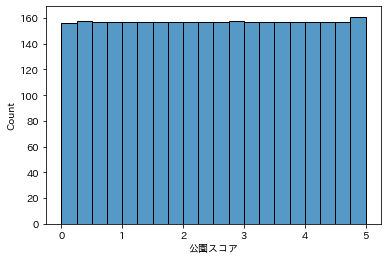

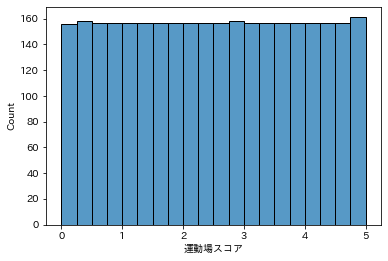

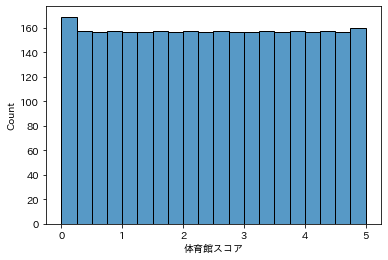

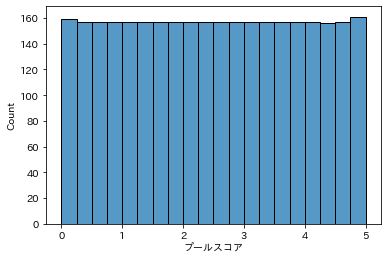

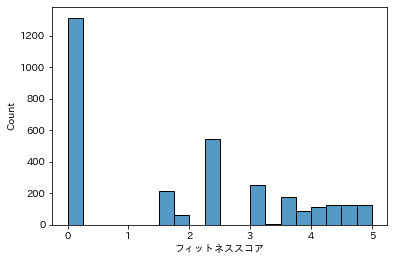

In [34]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [35]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1) # skipna=False
df_geo_master[score_name] = rank_score(_tmp_score)

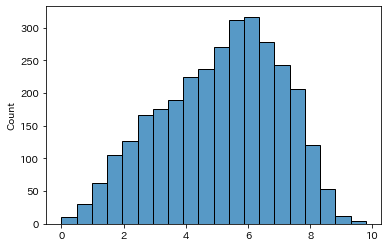

In [36]:
sns.histplot(_tmp_score, bins=20)
plt.show()

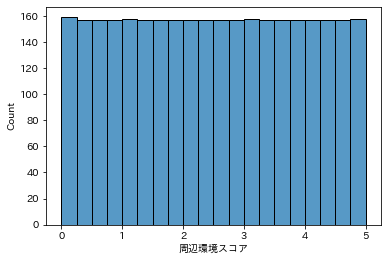

In [37]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [38]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.498807
std         1.444754
min         0.000000
25%         1.248210
50%         2.498807
75%         3.749403
max         5.000000
Name: 周辺環境スコア, dtype: float64

In [39]:
df_geo_master[score_name] = df_geo_master[score_name].round(2)

In [40]:
df_geo_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True, encoding='utf-8_sig')

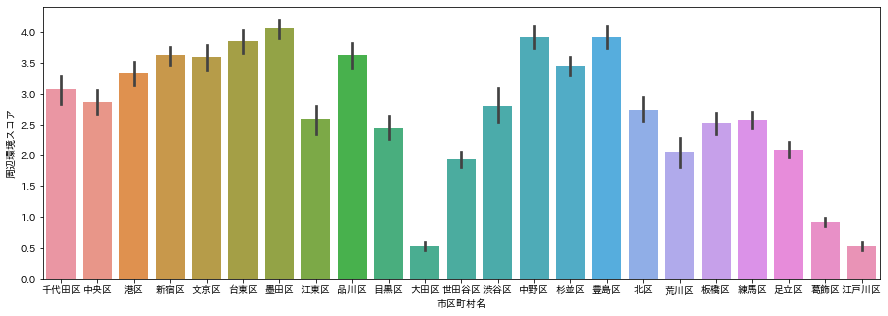

In [41]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_geo_master)
plt.show()

In [42]:
df_level = df_geo_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(907, 9)


In [43]:
df_level.head(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,フィットネススコア,周辺環境スコア
0,新宿区,高田馬場,高田馬場４丁目,4.86,4.75,4.83,4.04,4.17,5.00
1,渋谷区,幡ケ谷,幡ケ谷１丁目,4.40,4.17,4.67,4.57,4.69,5.00
2,江東区,亀戸,亀戸４丁目,4.78,4.13,4.35,2.30,4.98,4.99
3,渋谷区,笹塚,笹塚３丁目,4.71,2.42,4.38,4.54,4.12,4.99
4,杉並区,高円寺南,高円寺南１丁目,4.74,4.33,4.26,3.60,4.40,4.99
5,中野区,南台,南台５丁目,4.96,3.43,3.16,3.88,3.68,4.98
6,渋谷区,西原,西原１丁目,4.02,4.65,4.90,4.97,2.42,4.98
7,杉並区,和田,和田３丁目,4.20,4.87,4.12,3.73,4.40,4.98
8,新宿区,上落合,上落合１丁目,4.64,4.97,3.47,2.67,4.40,4.98
9,台東区,浅草橋,浅草橋４丁目,4.28,4.00,3.71,4.94,3.68,4.98


In [44]:
df_level.tail(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,フィットネススコア,周辺環境スコア
897,大田区,西蒲田,西蒲田７丁目,0.18,0.07,1.67,0.70,3.23,0.20
898,大田区,羽田旭町,羽田旭町,0.08,1.65,0.62,1.97,0.00,0.13
899,江戸川区,二之江町,二之江町,0.15,1.49,1.16,1.08,0.00,0.11
900,江戸川区,一之江町,一之江町,0.13,1.76,0.93,0.79,0.00,0.09
901,江戸川区,西瑞江,西瑞江５丁目,0.06,0.61,0.86,0.72,2.42,0.09
902,江戸川区,一之江,一之江５丁目,0.14,0.95,0.39,0.20,2.42,0.08
903,大田区,羽田空港,羽田空港１丁目,0.11,1.18,0.27,1.01,0.00,0.03
904,江戸川区,堀江町,堀江町,0.13,0.34,0.22,0.08,0.00,0.01
905,大田区,羽田沖水面,羽田沖水面,0.00,0.00,0.00,0.00,0.00,0.00
906,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,0.00,0.00,0.00,0.00,0.00,0.00
